# Driving in Circles

AutomotiveDrivingModels is templated to efficiently run different types of simulations.
Entities are parameterized by their:

- *S* state, which changes over time
- *D* defintion, which does not change over time
- *I* id, typically an `Int`, which uniquely identifies that entity.

In addition to these types, the actions, environment and the driver models can also be parameterized.

This notebook demonstrates a 2D driving simulation where cars drive in a multi-lane stadium.
The types are:

- *S* - `VehicleState`, containing both the global and lane-relative position, and speed
- *D* - `VehicleDef`, containing length, width, and class
- *I* - `Int`

We use a `Roadway` as our environment. The `Roadway` type is based on the RNDF format.

In [3]:
using AutomotiveDrivingModels
using AutoViz

We generate a 3-lane stadium roadway:

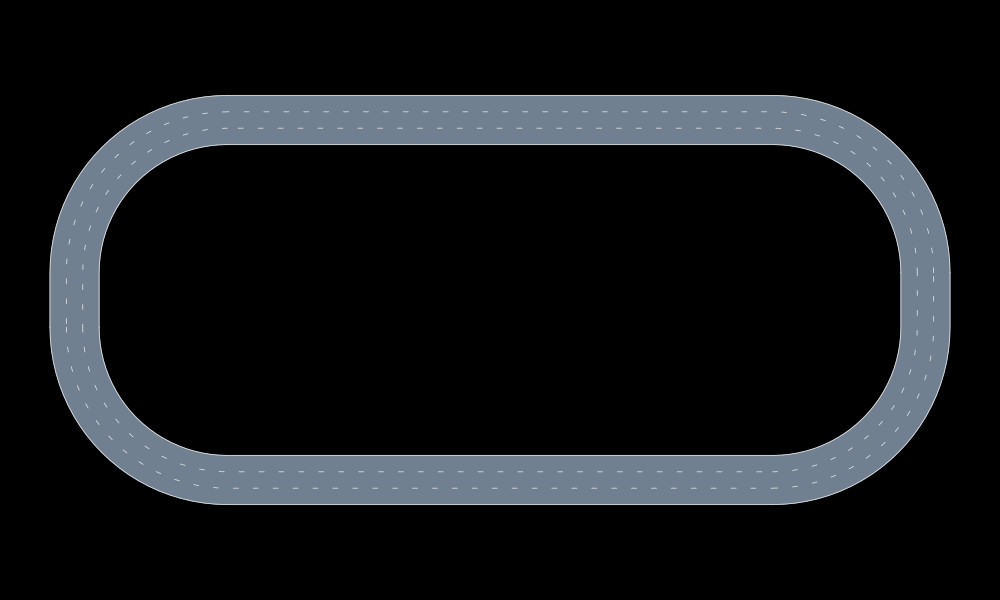

In [4]:
roadway = gen_stadium_roadway(3)

Let's populate a scene.

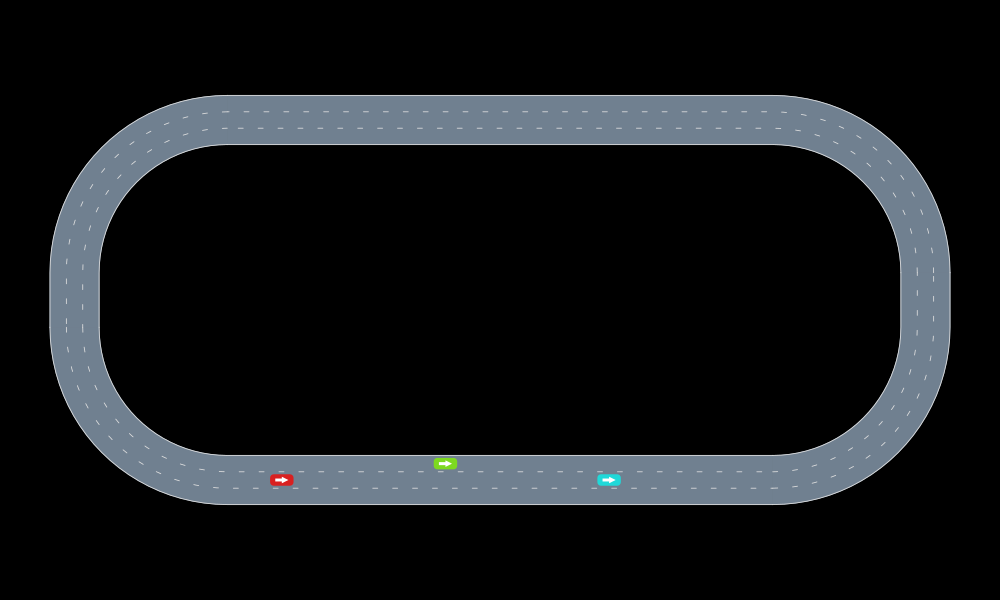

In [5]:
scene = Scene()
push!(scene,Vehicle(VehicleState(VecSE2(10.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 29.0), VehicleDef(), 1))
push!(scene,Vehicle(VehicleState(VecSE2(40.0,0.0,0.0), roadway, 22.0), VehicleDef(), 2))
push!(scene,Vehicle(VehicleState(VecSE2(70.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 27.0), VehicleDef(), 3))

car_colors = get_pastel_car_colors(scene)
cam = FitToContentCamera()
render(scene, roadway, cam=cam, car_colors=car_colors)

Let's assign driver models.

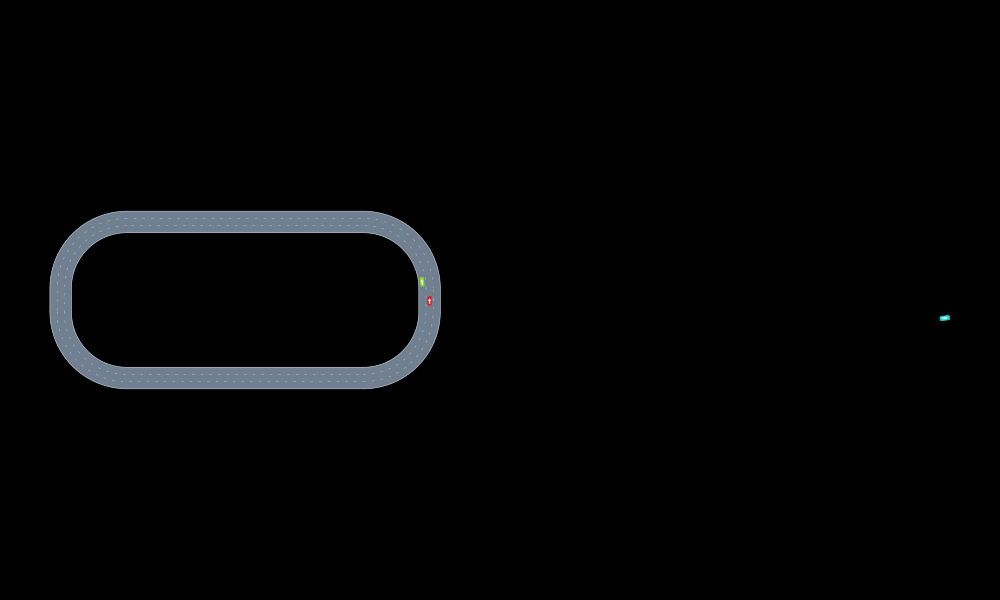

In [6]:
timestep = 0.1

models = Dict{Int, DriverModel}()
models[1] = LatLonSeparableDriver( # produces LatLonAccels
        ProportionalLaneTracker(), # lateral model
        IntelligentDriverModel(), # longitudinal model
)
models[2] = Tim2DDriver(timestep,
        mlane = MOBIL(timestep),
    )
models[3] = StaticDriver{AccelTurnrate, MvNormal}(MvNormal([0.0,0.0], [1.0,0.1]))

set_desired_speed!(models[1], 12.0)
set_desired_speed!(models[2], 10.0)
set_desired_speed!(models[3],  8.0)

nticks = 100
rec = SceneRecord(nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)
render(rec[0], roadway, cam=cam, car_colors=car_colors)

We can use interact to inspect the simulation record. Note that the static driver just drives off the road.

In [ ]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, car_colors=car_colors)
end

┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/d6ef759653977473236b6b5b4aa24c601d804f35-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/d6ef759653977473236b6b5b4aa24c601d804f35-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

We can save the run to a text file. We achieve this by first converting the the `Trajdata` type and then exporting that.

In [ ]:
listrec = convert(Trajdata, rec)
open("2Dstadium_listrec.txt", "w") do io
    write(io, MIME"text/plain"(), listrec)
end

The file can be loaded in a similar way.

In [ ]:
listrec2 = open("2Dstadium_listrec.txt", "r") do io
    read(io, MIME"text/plain"(), Trajdata)
end